# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Data Pre-processing

In [2]:
df = pd.read_csv("AirtrafficA4.csv")
for col in df.columns[3:-2]:
    df[col] = pd.to_numeric(df[col].str.replace(",", ""), errors="coerce").astype(
        "Int64"
    )

df[df.columns[-2]] = pd.to_numeric(
    df[df.columns[-2]].str.replace(",", ""), errors="coerce"
).astype("float64")
df[df.columns[-1]] = pd.to_numeric(
    df[df.columns[-1]].str.replace(",", ""), errors="coerce"
).astype("float64")
df["MONTH"] = (
    df["MONTH"].apply(lambda x: x.strip()).replace("JUNE", "JUN").replace("JULY", "JUL")
)

df["MONTH"] = pd.to_datetime(df["YEAR"].astype(str) + "-" + df["MONTH"], format="%Y-%b")
df = df.drop("YEAR", axis=1)
df = df.sort_values("MONTH", ignore_index=True)

# Prompt Engineering

In [3]:
train_size = int(0.9 * len(df))
train, test = df[:train_size], df[train_size:]

In [4]:
prompt = (
    "You are a helpful AI assistant, who makes accurate time series predictions. "
    + "The user will provide a sequence of months and the number of passengers for each month. "
    + "A data point is represented by a date string in %Y-%b format followed by a comma, followed by the number of passengers. "
    + "Missing data is represented by the date string in %Y-%b format followed by a comma, followed by <NA>. "
    + "The user will provide a sequence of data points, each separated by a newline. "
)
additional_prompt = (
    "Please print the number of passengers for the next k months, where k will be specified before the data. "
    + "Output only the numbers, not the dates. "
    + "Each prediction should be separated by a comma with no space. "
    + "Do not output any other text. "
)
additional_prompt_2 = (
    "There are outliers due to COVID-19 in the data. Please take care of those while making predictions. "
    + "Do not simply do linear interpolation."
    + "Make use of the seasonality and the increasing/decreasing trend of the sequence as it is not stationary. "
    + "During COVID-19 the increasing trend is really weak, that is why consider the part before 2020 and after 2021 to fit to the trends. "
    + "First value in your predictions should be close to the last value of the sequence that I input."
    + "\nSequence:"
)
string = f" k={len(test)}\n" + "\n".join(
    f"{row['MONTH'].strftime('%Y-%b')},{row['PASSENGERS CARRIED']}"
    for _, row in train.iterrows()
)

In [5]:
print(prompt + "\n" + additional_prompt + "\n" + additional_prompt_2 + "\n" + string)

You are a helpful AI assistant, who makes accurate time series predictions. The user will provide a sequence of months and the number of passengers for each month. A data point is represented by a date string in %Y-%b format followed by a comma, followed by the number of passengers. Missing data is represented by the date string in %Y-%b format followed by a comma, followed by <NA>. The user will provide a sequence of data points, each separated by a newline. 
Please print the number of passengers for the next k months, where k will be specified before the data. Output only the numbers, not the dates. Each prediction should be separated by a comma with no space. Do not output any other text. 
There are outliers due to COVID-19 in the data. Please take care of those while making predictions. Do not simply do linear interpolation.Make use of the seasonality and the increasing/decreasing trend of the sequence as it is not stationary. During COVID-19 the increasing trend is really weak, th

# Output Processing

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
llm_output = input()
pred = np.array([int(a) for a in llm_output.split(",")])
print(f"The MAPE is {mean_absolute_percentage_error(test['PASSENGERS CARRIED'].values, pred)}")

5821644,6092159,6270152,6375048,6201073,6359447,6457765,6631258,6352085,6602181,6720386,6849075,6900833
The MAPE is 8.465705432372493


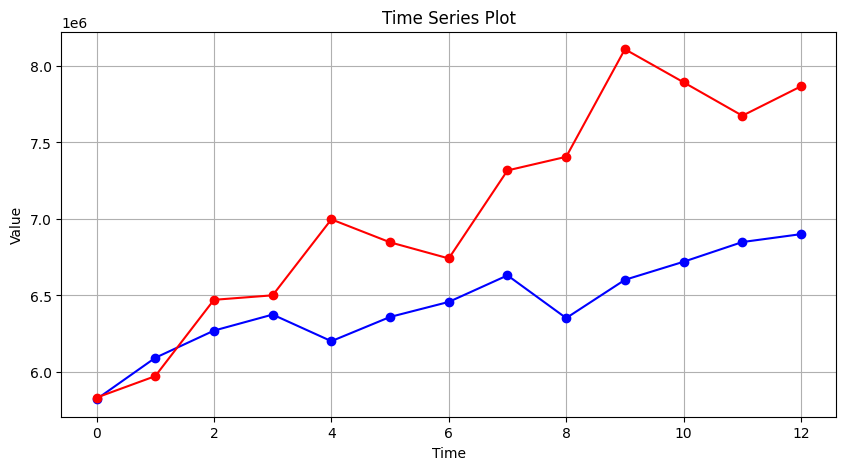

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(pred, marker='o', linestyle='-', color='b', label='Predicted')
plt.plot(test['PASSENGERS CARRIED'].values, marker='o', linestyle='-', color='r', label='Actual')
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# Prediction Next 12 Months

In [9]:
prompt = "Sequence: k=12\n"
string = "\n".join(
    f"{row['MONTH'].strftime('%Y-%b')},{row['PASSENGERS CARRIED']}"
    for _, row in df.iterrows()
)
print(prompt + string)

Sequence: k=12
2013-Jan,1408012
2013-Feb,1341210
2013-Mar,1423569
2013-Apr,1511094
2013-May,1685168
2013-Jun,1480879
2013-Jul,1445248
2013-Aug,1531406
2013-Sep,1378691
2013-Oct,1510184
2013-Nov,1467763
2013-Dec,1575872
2014-Jan,1426580
2014-Feb,1464070
2014-Mar,1601141
2014-Apr,1679963
2014-May,1908334
2014-Jun,1797101
2014-Jul,1599977
2014-Aug,1858664
2014-Sep,1907378
2014-Oct,1890273
2014-Nov,1967992
2014-Dec,2324221
2015-Jan,2276404
2015-Feb,2230645
2015-Mar,2286128
2015-Apr,2481285
2015-May,2769283
2015-Jun,2536554
2015-Jul,2416916
2015-Aug,2384943
2015-Sep,2430449
2015-Oct,2589861
2015-Nov,2597765
2015-Dec,2743325
2016-Jan,2725711
2016-Feb,2754131
2016-Mar,3023228
2016-Apr,3066556
2016-May,3336839
2016-Jun,3023081
2016-Jul,3383768
2016-Aug,3341081
2016-Sep,3295826
2016-Oct,3692828
2016-Nov,3772583
2016-Dec,3848322
2017-Jan,3809228
2017-Feb,3418605
2017-Mar,3611371
2017-Apr,3778780
2017-May,4190914
2017-Jun,3825814
2017-Jul,3699451
2017-Aug,3678245
2017-Sep,3664509
2017-Oct,4133027

In [10]:
llm_output = input()
pred = np.array([int(a) for a in llm_output.split(",")])

7835123,8020548,8198962,8274010,8097684,8233897,8390546,8563281,8297216,8539728,8681752,8769829


<ipython-input-11-bab5285e0f32>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')


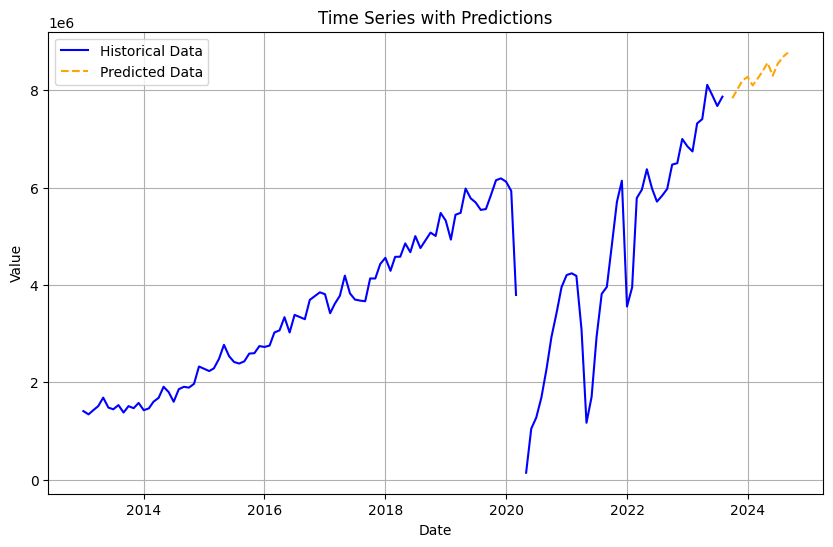

In [11]:
df = df.set_index("MONTH")

last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')

pred_df = pd.DataFrame(pred, index=future_dates, columns=['PASSENGERS CARRIED'])

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['PASSENGERS CARRIED'], label='Historical Data', color='blue')

plt.plot(pred_df.index, pred_df['PASSENGERS CARRIED'], label='Predicted Data', color='orange', linestyle='--')

plt.title('Time Series with Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()